### **Mount Google Drive/Parent Directory**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### **Install and Import Libraries**

In [3]:
# Library for image registration and others
!pip install SimpleITK-SimpleElastix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import cv2
import numpy as np                                            
import matplotlib.pyplot as plt                 
from google.colab.patches import cv2_imshow
import pandas as pd
import os
import SimpleITK as sitk
from scipy.signal import medfilt, lfilter
from skimage import exposure, metrics
from scipy.stats import multivariate_normal
import pickle

**Image Slice Visualization**

In [5]:
# Visualize 2D Slice from 3D Image
def slice_show(image, slice_no, title):
  """
  Function to visualiza each slice of the 3D image
  Inputs: 
  image => Sitk Image that need to be visualized,
  slice_no => Slice Number
  title => The title of the Image

  output: Plot Image.

  """ 
  flip = np.flipud(image)
  plt.figure()
  plt.axis('off')
  plt.title(title)
  plt.imshow(flip[:,:,slice_no], cmap='gray') 

**SITK and Numpy Conversion**

In [6]:
def SITKtoArray(itk_image):
  """
  Function to convert Sitk Image to Numpy Array
  Inputs: 
  itk_image => Sitk Image that needs to be converted,

  output: Converted Numpy Array.

  """ 
  return np.moveaxis(sitk.GetArrayFromImage(itk_image),0,-1)

In [7]:
def ArraytoSITK(array, reference_image):
  """
  Function to convert Numpy Array to Sitk Image
  Inputs: 
  array => numpy array that needs to be converted,
  reference_image => image which metadata will be copied

  output: Converted sitk image.

  """
  image= sitk.GetImageFromArray(np.moveaxis(array,-1,0))
  image.CopyInformation(reference_image)
  return image

### **Evaluation Metric**

In [8]:
def tissue_visualization(Seg_CSF, GT_CSF, Seg_WM, GT_WM, Seg_GM, GT_GM, number_of_slice):

  """
  Inputs: 
  Seg_CSF => CSF class data of the brain tissue after segmentation,
  GT_CSF => Ground truth of CSF Class,
  Seg_GM => GM class data of the brain tissue after segmentation,
  GT_GM => Ground truth of GM Class,
  Seg_WM => WM class data of the brain tissue after segmentation,
  GT_WM => Ground truth of WM Class,
  
  output: Plot Images.

  """ 

  #Visualize each tissue separately
  fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots( 2, 3, figsize=(10,6))

  ax1.set_title("Class CSF #{}".format(number_of_slice))
  img1 = ax1.imshow(Seg_CSF[:,:,number_of_slice], cmap = "gray")
  ax2.set_title("Class WM #{}".format(number_of_slice))
  img2 = ax2.imshow(Seg_WM[:,:,number_of_slice], cmap = "gray")
  ax3.set_title("Class GM #{}".format(number_of_slice))
  img3 = ax3.imshow(Seg_GM[:,:,number_of_slice], cmap = "gray")
  ax4.set_title("Ground Truth CSF #{}".format(number_of_slice))
  img4 = ax4.imshow(GT_CSF[:,:,number_of_slice], cmap = "gray")
  ax5.set_title("Ground Truth of WM #{}".format(number_of_slice))
  img5 = ax5.imshow(GT_WM[:,:,number_of_slice], cmap = "gray")
  ax6.set_title("Ground Truth of GM #{}".format(number_of_slice))
  img6 = ax6.imshow(GT_GM[:,:,number_of_slice], cmap = "gray")
  

  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  ax4.axis('off')
  ax5.axis('off')
  ax6.axis('off')
  plt.tight_layout()
  plt.show()

In [9]:
def diceScoreSimilarity(segmented_image, ground_truth):
  
    """
    Inputs: 
    segmented_image => Segmeneted image,
    ground_truth => ground truth,

    output: Dice Score for all the three classes separately.

    """ 
           
    # Compute DICE
    def dice(SI, GT):
      #   2 * TP / (FN + (2 * TP) + FP)
      intersection = np.logical_and(SI, GT)
      return 2. * intersection.sum() / (SI.sum() + GT.sum())
    
    # Dice  for CSF
    Seg_CSF = (segmented_image == 1)
    GT_CSF = (ground_truth == 1)
    dice_CSF = dice(Seg_CSF, GT_CSF)
    # Dice  for GM
    Seg_GM = (segmented_image == 2)
    GT_GM = (ground_truth == 2)
    dice_GM = dice(Seg_GM, GT_GM)
    # Dice  for WM
    Seg_WM = (segmented_image == 3)
    GT_WM = (ground_truth == 3)
    dice_WM = dice(Seg_WM, GT_WM)

    #  Visualize each tissue class separately
    number_of_slice = 141
    tissue_visualization(Seg_CSF, GT_CSF, Seg_WM, GT_WM, Seg_GM, GT_GM, number_of_slice)

    return dice_CSF, dice_WM, dice_GM

### **Data Loading**

In [10]:
# Directories
input_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MISA/'
train_directory = input_directory+'Training_Set' 
val_directory = input_directory+'Validation_Set'
test_directory = input_directory+'Test_Set'
# Directories where data will be saved
saved_data= input_directory + 'Saved_Data'
saved_data_directory_train= input_directory+'Saved_Data/train'
saved_data_directory_val= input_directory+'Saved_Data/val'
saved_data_directory_test= input_directory+'Saved_Data/test'

In [11]:
def loadData(directory):
  """
  Function to load data with desired format from a given directory.
  Inputs: 
  directory => either train or val or test data directory,

  output: 3 lists containing images, labels and their names.

  """ 

  labels_metadata = []
  images_metadata = []
  images_names= []
  
  for folders in sorted(os.listdir(directory)):
    images_names.append(folders)
    images_directory = os.path.join(directory, folders)
    for files in sorted(os.listdir(images_directory)):
      if '_seg' in files:
        # Accessing the labels/ground truths
        label_paths = os.path.join(images_directory, files)
        label_data = sitk.ReadImage(label_paths)
        labels_metadata.append(label_data)
      else:
      # if '.DS' not in files:
        # Accessing the images
        image_paths = os.path.join(images_directory, files)
        image_data = sitk.ReadImage(image_paths)
        images_metadata.append(image_data)
  return images_metadata, labels_metadata, images_names

In [12]:
# Training Images and labels
train_images_metadata = []
train_labels_metadata = []
train_images_metadata, train_labels_metadata, train_images_names = loadData(train_directory)
# Validation Images and labels
val_images_metadata = []
val_labels_metadata = []
val_images_metadata, val_labels_metadata, val_images_names = loadData(val_directory)
# Test Images
test_images_metadata = []
test_images_metadata, _, test_images_names= loadData(test_directory)

In [13]:
# Check
print(len(train_labels_metadata))
print(len(train_images_metadata))
print(len(val_labels_metadata))
print(len(val_images_metadata))
print(len(test_images_metadata))

10
10
5
5
3


### **Preprocessing Steps**

**Bias Correction**

In [14]:
def N4BiasCorrection(input_img_metadata):
  """
  Function  for correcting low frequency intensity non-uniformity present in MRI image

  """
  # Mask that specifies which pixels are used to estimate the bias-field  
  sitk_mask = sitk.OtsuThreshold(input_img_metadata, 0, 1, 200)
  # Casting the image to be in Float32 type
  sitk_img_float = sitk.Cast(input_img_metadata, sitk.sitkFloat32)
  # Creating Bias Corrector Filter
  corrector = sitk.N4BiasFieldCorrectionImageFilter()
  # Finally Bias correction is performed
  bias_corrected_img = corrector.Execute(sitk_img_float, sitk_mask)
  return bias_corrected_img

**Denoising**

In [15]:
def denoise(input_img, kernel_size=3):
  """
  Function that uses a median filter with a given kernel size to denoise the image
  
  """
  return medfilt(input_img, kernel_size)

**Normalization**

In [16]:
def normalization(input_img):
  """
  Function that normalizes the image in min-max form.
  
  """
  img = input_img.copy()
  # Minimum intensity present in the image
  min_intensity = img.min()
  # Maximum intensity present in the image
  max_intensity = img.max()
  # Image Normalization
  img_normalized = ( input_img - min_intensity ) / ( max_intensity - min_intensity )
  return img_normalized

**CLAHE**

In [17]:
def apply_clahe(input_img):
  """
  Function that performs contrast-limited adaptive histogram equalization on a given image.
  
  """
  img= input_img.copy()
  # Applying clahe on a given image (library taken from skimage)
  clahe_img = exposure.equalize_adapthist(img, clip_limit=0.01)
  return clahe_img

**Preprocessing**

In [18]:
def preprocessing(input_img_metadata):
  """
  Function that performs all the preprocessing steps on a given image.
  
  """
  input_img = np.moveaxis(sitk.GetArrayFromImage(input_img_metadata),0,-1)
  slice_show(input_img, 144, 'Input Image')
  # Bias Correction
  bias_img = N4BiasCorrection(input_img_metadata)
  bias_corrected_img = np.moveaxis(sitk.GetArrayFromImage(bias_img),0,-1)
  slice_show(bias_corrected_img, 144, 'Bias Corrected Image')
  # Image Denoising
  denoised_img = denoise(bias_corrected_img)
  slice_show(denoised_img, 144, 'Denoised Image')
  # Image Noramlization
  normalized_img = normalization(denoised_img)
  slice_show(normalized_img, 144, 'Normalized Image')
  # Adaptive Histogram Equalization
  clahe_img = apply_clahe(normalized_img)
  slice_show(clahe_img, 144, 'Clahe Image')
  return clahe_img

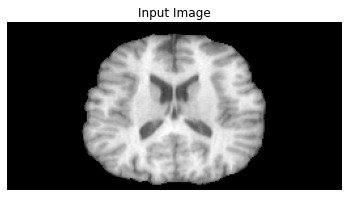

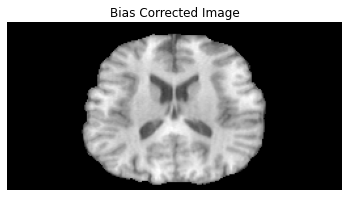

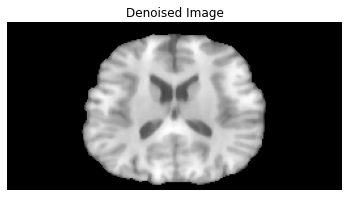

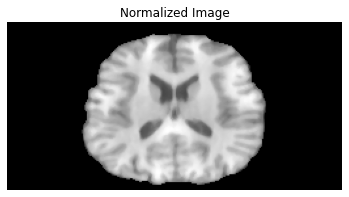

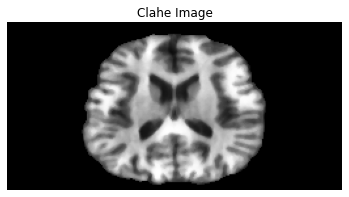

In [19]:
preprocessed_img = preprocessing(train_images_metadata[0])

### **Preprocessing Pipeline**

**Training Set**

In [ ]:
# Preprocessing training images and storing
train_preprocessed_images = []
for data in train_images_metadata:
  preprocessed_img = preprocessing(data)
  train_preprocessed_images.append(preprocessed_img)

In [ ]:
pickle.dump(train_preprocessed_images, open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/train_preprocessed_images.sav', 'wb'))

In [ ]:
train_preprocessed_images= pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/train_preprocessed_images.sav', 'rb'))

In [ ]:
# Storing preprocessed training images
for i in range(len(train_preprocessed_images)): 
  image= ArraytoSITK(train_preprocessed_images[i],train_images_metadata[i])
  sitk.WriteImage(image, saved_data_directory_train+'/'+train_images_names[i]+'_preprocessed.nii.gz')

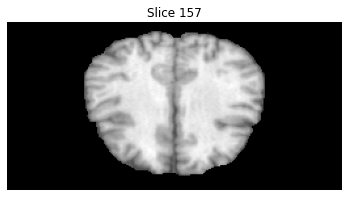

In [ ]:
# Check before preprocessing
slice_show(SITKtoArray(train_images_metadata[0]),157,'Slice 157')

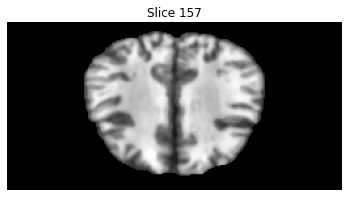

In [ ]:
# Check After preprocessing
slice_show(train_preprocessed_images[0],157,'Slice 157')

**Validation Set**

In [ ]:
# Preprocessing Validation images and storing
val_preprocessed_images = []
for data in val_images_metadata:
  preprocessed_img = preprocessing(data)
  val_preprocessed_images.append(preprocessed_img)

In [ ]:
pickle.dump(val_preprocessed_images, open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/val_preprocessed_images.sav', 'wb'))

In [ ]:
val_preprocessed_images= pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/val_preprocessed_images.sav', 'rb'))

In [ ]:
# Storing preprocessed validation images
for i in range(len(val_preprocessed_images)): 
  image= ArraytoSITK(val_preprocessed_images[i],val_images_metadata[i])
  sitk.WriteImage(image, saved_data_directory_val+'/'+val_images_names[i]+'_preprocessed.nii.gz')

**Test Set**

In [ ]:
# Preprocessing test images and storing
# test_preprocessed_images = []
# for data in test_images_metadata:
#   preprocessed_img = preprocessing(data)
#   test_preprocessed_images.append(preprocessed_img)

In [ ]:
# pickle.dump(test_preprocessed_images, open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/test_preprocessed_images.sav', 'wb'))

In [ ]:
# test_preprocessed_images= pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/test_preprocessed_images.sav', 'rb'))

In [ ]:
# Storing preprocessed test images
# for i in range(len(test_preprocessed_images)): 
#   image= ArraytoSITK(test_preprocessed_images[i], test_images_metadata[i])
#   sitk.WriteImage(image, saved_data_directory_test+'/'+test_images_names[i]+'_preprocessed.nii.gz')

### **Registration Pipeline**

**Resample Voxel Spacing**

In [ ]:
def resample_volume(image, new_spacing):
  """
  Function  for resampling the voxel-spacing of an image so that both fixed and moving image have same spacing for voxels before registration.
  Inputs:
  image => Image which voxel spacing needs to be resampled,
  new_spacing => desired voxel spacing.

  Output:
  New volume image with desired voxel spacing.

  """
  # Image cast to Float32 mode required
  volume = sitk.Cast(image,sitk.sitkFloat32)
  # Interpolator creation
  interpolator = sitk.sitkLinear
  # Get the current voxel spacing and size
  original_spacing = volume.GetSpacing()
  original_size = volume.GetSize()
  # Resampling
  new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
  return sitk.Resample(volume, new_size, sitk.Transform(), interpolator,
                        volume.GetOrigin(), new_spacing, volume.GetDirection(), 0,
                        volume.GetPixelID())

In [ ]:
def RegistrationFramework(fixed_preprocessed_images, fixed_images_metadata, moving_preprocessed_images, moving_images_metadata, moving_masks_metadata, parameter_list, output_directory):
  """
  Function for performing Image Registration.
  
  Inputs:
  fixed_preprocessed_images => Fixed Image list(numpy),
  fixed_images_metadata =>  Fixed Image list in Sitk format,
  moving_preprocessed_images => Moving Image list(numpy),
  moving_images_metadata =>  Moving Image list in Sitk format,
  moving_masks_metadata => Ground Truths list of Moving Images in Sitk format,
  parameter_list => Parameters that will be used by elastix for registration,
  output_directory => Directory where registered images will be saved.
  
  """
  for i in range(len(fixed_images_metadata)):
    # Accesing current fixed image from the list
    current_fixed_img = ArraytoSITK(fixed_preprocessed_images[i], fixed_images_metadata[i])
    fixed_output_directory = output_directory + '/' + val_images_names[i]
    if not os.path.exists(fixed_output_directory):
      os.makedirs(fixed_output_directory)
    for j in range(len(moving_images_metadata)):
      # Accesing current moving image from the list
      current_moving = ArraytoSITK(moving_preprocessed_images[j], moving_images_metadata[j])
      # Resampling the voxel spacing of the moving image according to the fixed one
      current_moving_img = resample_volume(current_moving, current_fixed_img.GetSpacing())
      # Registered Images will be saved in this directory
      current_output_directory = fixed_output_directory + '/' + train_images_names[j]
      if not os.path.exists(current_output_directory):
        os.makedirs(current_output_directory)
      output_registered_image = current_output_directory + '/registered_image.nii.gz'

      # Image registration steps using Elastix
      elastixImageFilter = sitk.ElastixImageFilter()
      elastixImageFilter.LogToConsoleOn()
      elastixImageFilter.SetFixedImage(current_fixed_img)
      elastixImageFilter.SetMovingImage(current_moving_img)
      parameterMapVector = sitk.VectorOfParameterMap()
      # If there are multiple parameter files, all will be appended in the vector
      for p in parameter_list:
        parameterMapVector.append(sitk.ReadParameterFile(p))
      elastixImageFilter.SetParameterMap(parameterMapVector)
      elastixImageFilter.Execute()

      # Accesing the deformation field from the registration performed
      transformed_parameter_map= elastixImageFilter.GetTransformParameterMap()
      sitk.WriteImage(elastixImageFilter.GetResultImage(),output_registered_image)

      # Label Propagation of the moving image to get the labels for fixed images after registration 
      output_transformed_label= current_output_directory +'/transformed_label.nii.gz'

      # Label Propagation using Transformix
      transformixImageFilter = sitk.TransformixImageFilter()
      transformixImageFilter.SetMovingImage(moving_masks_metadata[j])
      transformixImageFilter.SetTransformParameterMap(transformed_parameter_map)
      transformixImageFilter.SetOutputDirectory(current_output_directory)
      transformixImageFilter.Execute()

      # Finally storing the mask images
      sitk.WriteImage(transformixImageFilter.GetResultImage(), output_transformed_label)
      

**Image Registration**

In [ ]:
# Image Registration Pipeline
reg_output_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Registration_Results/'
# val_output_directory = reg_output_directory + 'val' # Without Voxel-Spacing Resampling
val_output_directory = reg_output_directory + 'val2' # With Voxel-Spacing Resampling
test_output_directory = reg_output_directory + 'test'

# Parameter that will be used for registration
parameter_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Parameters_Registration_10'
parameter_list = []
for files in sorted(os.listdir(parameter_directory)):
  param_directory = os.path.join(parameter_directory, files)
  parameter_list.append(param_directory)

In [ ]:
# Registration is performed on Validation Images 
RegistrationFramework(val_preprocessed_images, val_images_metadata, train_preprocessed_images, train_images_metadata, train_labels_metadata, parameter_list, val_output_directory)

In [ ]:
# parameter_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Parameters_Registration_09'
# parameter_list = []
# for files in sorted(os.listdir(parameter_directory)):
#   param_directory = os.path.join(parameter_directory, files)
#   parameter_list.append(param_directory)

**Validation Data**

In [ ]:
# Propagated Label Candiadate Lists for each registered images without voxel-spacing resampling
transformed_labels=[]
for folders in sorted(os.listdir(reg_output_directory + 'val')):
  labels=[]
  for candidates in sorted(os.listdir(reg_output_directory+'val/'+folders)):
    labels.append(sitk.ReadImage(reg_output_directory+'val/'+folders+'/'+candidates+'/transformed_label.nii.gz'))
  transformed_labels.append(labels)

In [ ]:
# Propagated Label Candiadate Lists in numpy array format for each registered images without voxel-spacing resampling
transformed_labels_data=[]
for elements in transformed_labels: 
  labels=[]
  for candidates in elements: 
    labels.append(SITKtoArray(candidates).astype(np.uint8))
  transformed_labels_data.append(labels)
      

In [ ]:
# Propagated Label Candiadate Lists for each registered images with voxel-spacing resampling
transformed_labels_with_voxel_spacing=[]
for folders in sorted(os.listdir(reg_output_directory + 'val2')):
  labels=[]
  for candidates in sorted(os.listdir(reg_output_directory+'val2/'+folders)):
    labels.append(sitk.ReadImage(reg_output_directory+'val2/'+folders+'/'+candidates+'/transformed_label.nii.gz'))
  transformed_labels_with_voxel_spacing.append(labels)

In [ ]:
# Propagated Label Candiadate Lists in numpy array format for each registered images without voxel-spacing resampling
transformed_labels_voxel_spacing_data=[]
for elements in transformed_labels_with_voxel_spacing: 
  labels=[]
  for candidates in elements: 
    labels.append(SITKtoArray(candidates).astype(np.uint8))
  transformed_labels_voxel_spacing_data.append(labels)
      

**Test Data**

## **Segmentation Pipeline**

In [ ]:
# Ground Truth Data
val_labels=[]
for i in val_labels_metadata: 
  val_labels.append(SITKtoArray(i).astype(np.uint8))

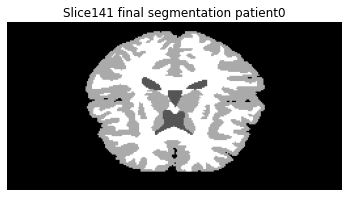

In [ ]:
slice_show(val_labels[0],141,'Slice141 final segmentation patient0')

In [ ]:
# Candiadate Lists for each registered images without voxel-spacing resampling
registered_images = []
for folders in sorted(os.listdir(reg_output_directory + 'val')):
  images = []
  for candidates in sorted(os.listdir(reg_output_directory+'val/'+folders)):
    images.append(SITKtoArray(sitk.ReadImage(reg_output_directory+'val/'+folders+'/'+candidates+'/registered_image.nii.gz')))
  registered_images.append(images)

In [ ]:
# Preprocessed Fixed Images (Validation Images)
val_images=[]
for files in os.listdir(saved_data_directory_val):
  images = sitk.ReadImage(os.path.join(saved_data_directory_val, files))
  images_float = sitk.Cast(images, sitk.sitkFloat32)
  val_images.append(SITKtoArray(images_float))

### **Majority voting**

In [ ]:
def majority_voting(segmentation_candidates):

  """
  Function to perform majority voting from the propagated labels in registration step to perform final segmentation.
  Inputs:
  segmentation_candidates => A list of lists containing all the candidate labels resulted after image registration step,

  Output:
  A list containing all the segmentation masks.
  """ 

  # Create an empty list to store the final segmentation maps
  final_segmentations = []
  
  # Iterate over each set of segmentation candidates
  for candidates in segmentation_candidates:
    # Get the shape of the segmentation maps
    M, N, O = candidates[0].shape
    # Create an empty array to store the final segmentation map for this image
    final_segmentation = np.zeros((M, N, O), dtype=np.uint8)
    
    # Iterate over each voxel in the image
    for i in range(M):
      for j in range(N):
        for k in range(O):
          # Compute the majority label at this voxel
          labels, counts = np.unique([seg[i, j, k] for seg in candidates], return_counts=True)
          final_segmentation[i, j, k] = labels[np.argmax(counts)]
          
    # Add the final segmentation map for this image to the list
    final_segmentations.append(final_segmentation)
    
  return final_segmentations

In [ ]:
# Performing Majority Voting
final_segmentations_majority_voting = majority_voting(transformed_labels_data)

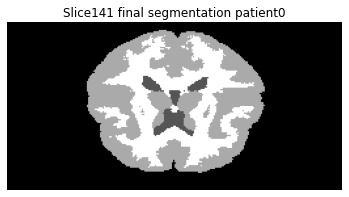

In [ ]:
# Check
slice_show(final_segmentations_majority_voting[0], 141, 'Slice141 final segmentation patient0')

In [ ]:
dice_scores=[]
for i in range(len(final_segmentations_majority_voting)): 
  dice_CSF,dice_GM, dice_WM =  diceScoreSimilarity(final_segmentations_majority_voting[i], val_labels[i])
  dice_scores.append([dice_CSF,dice_GM,dice_WM])
  print("For patient {}, the Dice Score for CSF, GM and WM were {:.4f},{:.4f},{:.4f}, respectively".format(i+1,dice_CSF, dice_GM, dice_WM))
dice_scores= np.array(dice_scores)
mean_dice= np.mean(dice_scores,axis=0)
print("In average, the dice score for CSF, GM and WM are {:.4f},{:.4f},{:.4f}, respectively".format(mean_dice[0],mean_dice[1],mean_dice[2]))

For patient 1, the Dice Score for CSF, GM and WM were 0.7758,0.7852,0.8238, respectively
For patient 2, the Dice Score for CSF, GM and WM were 0.8143,0.7991,0.8292, respectively
For patient 3, the Dice Score for CSF, GM and WM were 0.7601,0.7863,0.8715, respectively
For patient 4, the Dice Score for CSF, GM and WM were 0.8020,0.8058,0.8670, respectively
For patient 5, the Dice Score for CSF, GM and WM were 0.8636,0.7765,0.8702, respectively
In average, the dice score for CSF, GM and WM are 0.8031,0.7906,0.8524, respectively


In [ ]:
# Storing Final Segmentation Results using Majority Voting
pickle.dump(final_segmentations_majority_voting, open(saved_data+'/final_segmentations_majority_voting', 'wb'))

### **Weighted-Majority Voting**

In [ ]:
# Finding Similarity Weight for all the validation images
similarity_value_list = []
for i in range(len(val_images)):
  current_similarity_value_list = []
  for j in range(len(registered_images[i])):
    # Finding Structural Similarity Value for each pair
    similarity_value = metrics.structural_similarity(val_images[i], registered_images[i][j])
    current_similarity_value_list.append(similarity_value)
  similarity_value_list.append(current_similarity_value_list)

In [ ]:
def weighted_majority_voting(segmentation_candidates, similarity_value_list):

  """
  Function to perform weighted majority voting from the propagated labels in registration step to perform final segmentation.
  Inputs:
  segmentation_candidates => A list of lists containing all the candidate labels resulted after image registration step,
  similarity_value_list => A list of lists containing structural similarity index value between each validation image and it's corresponding registered image with each training images.
  
  Output:
  A list containing all the segmentation masks.
  """ 

  # Create an empty list to store the final segmentation maps
  final_segmentations = []
  
  # Iterate over each set of segmentation candidates
  for c in range(len(segmentation_candidates)):
    candidates = segmentation_candidates[c]
    # Get the shape of the segmentation maps
    M, N, O = candidates[0].shape
    # Create an empty array to store the final segmentation map for this image
    final_segmentation = np.zeros((M, N, O), dtype=np.uint8)
    # Iterate over each voxel in the image
    for i in range(M):
      for j in range(N):
        for k in range(O):
          # Compute the weighted majority label at this voxel
          label_weight_matrix = np.zeros((4), dtype=np.float32)
          for seg in range(len(candidates)):
            current_candidate = candidates[seg]
            current_label = current_candidate[i, j, k]
            current_weight = similarity_value_list[c][seg]
            label_weight_matrix[current_label]+=current_weight
          final_segmentation[i, j, k] = np.argmax(label_weight_matrix)

    # Add the final segmentation map for this image to the list
    final_segmentations.append(final_segmentation)
    
  return final_segmentations

In [ ]:
# Performing Weighted Majority Voting
final_segmentations_weighted_majority_voting = weighted_majority_voting(transformed_labels_data, similarity_value_list)

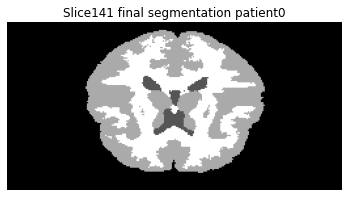

In [ ]:
# Check
slice_show(final_segmentations_weighted_majority_voting[0], 141, 'Slice141 final segmentation patient0')

In [ ]:
dice_scores=[]
for i in range(len(final_segmentations_weighted_majority_voting)): 
  dice_CSF,dice_GM, dice_WM =  diceScoreSimilarity(final_segmentations_weighted_majority_voting[i], val_labels[i])
  dice_scores.append([dice_CSF,dice_GM,dice_WM])
  print("For patient {}, the Dice Score for CSF, GM and WM were {:.4f},{:.4f},{:.4f}, respectively".format(i+1,dice_CSF, dice_GM, dice_WM))
dice_scores= np.array(dice_scores)
mean_dice= np.mean(dice_scores,axis=0)
print("In average, the dice score for CSF, GM and WM are {:.4f},{:.4f},{:.4f}, respectively".format(mean_dice[0],mean_dice[1],mean_dice[2]))

For patient 1, the Dice Score for CSF, GM and WM were 0.7854,0.7994,0.8244, respectively
For patient 2, the Dice Score for CSF, GM and WM were 0.7990,0.8001,0.8239, respectively
For patient 3, the Dice Score for CSF, GM and WM were 0.7594,0.7798,0.8627, respectively
For patient 4, the Dice Score for CSF, GM and WM were 0.8069,0.8091,0.8643, respectively
For patient 5, the Dice Score for CSF, GM and WM were 0.8514,0.7798,0.8694, respectively
In average, the dice score for CSF, GM and WM are 0.8004,0.7936,0.8489, respectively


In [ ]:
# Storing Final Segmentation Results using Majority Voting
pickle.dump(final_segmentations_weighted_majority_voting, open(saved_data+'/final_segmentations_weighted_majority_voting', 'wb'))

### **EM**

**EM - Initialization from Label Propagation**

In [ ]:
final_segmentations_majority_voting = pickle.load(open(saved_data+'/final_segmentations_majority_voting', 'rb'))

In [ ]:
def label_prop_initialization(input_image, labels_data):
    
    input_image= input_image.astype(int) 
    feature_data = input_image.copy().flatten() # Flattening the image
  
    # Assigning classes to tissues
    current_label_image = labels_data.flatten()

    CSF_tissue = feature_data[current_label_image == 1]
    GM_tissue = feature_data[current_label_image == 2]
    WM_tissue = feature_data[current_label_image == 3]

    # Computing mean and covariance
    mean_CSF = np.mean(CSF_tissue, axis = 0)
    mean_GM = np.mean(GM_tissue , axis = 0)
    mean_WM = np.mean(WM_tissue, axis = 0)
    cov_CSF = np.cov(CSF_tissue, rowvar = False)
    cov_GM = np.cov(GM_tissue , rowvar = False)
    cov_WM = np.cov(WM_tissue, rowvar = False)
    
    mean_generation = np.vstack((mean_CSF, mean_GM, mean_WM))
    covariance_computation = np.stack((cov_CSF, cov_GM, cov_WM))

    # Computing prior probabilities of each class
    pp_CSF = CSF_tissue.shape[0]/feature_data.shape[0]
    pp_GM = GM_tissue.shape[0]/feature_data.shape[0]
    pp_WM = WM_tissue.shape[0]/feature_data.shape[0]

    a_vector = np.vstack((pp_CSF, pp_GM, pp_WM))
   
    return mean_generation, covariance_computation, a_vector

**EM Algorithm - Expectation**

In [ ]:
def ExpectationStep(gmm):

  """
  Inputs: 
  gmm => matrix containing the gaussian mixture models (probability density functions).
  The size of this matrix is (N,clusters), where N corresponds to the number of datapoints for each
  one of the modalities
  and K corresponds to the number of clusters (tissues to be segmented)
  
  output: weights_vector=> Updated membership weights for all data points 

  """ 

  #Parameter gmm: Mixture model for the current datapoint
  numerator= gmm 
  #Denominator of the equation
  denominator= np.sum(gmm, axis=1)
  denominator= denominator.reshape((denominator.shape[0],1))
  #Update of membership weights
  weights_vector= numerator/(denominator+1e-10)

  return weights_vector

**EM Algorithm - Maximization**

In [ ]:
def MaximizationStep(x, weights_vector):

  """
  Inputs: 
  x=> dataset vector 
  weights_vector => membership weights for all datapoints 

  output: new_parameters => dictionary containing updated parameters for the current
  iteration: alpha (mixture weights), mean and covariance.

  """ 

  #Number of datapoints for each modality
  N= x.shape[0]
  #Sum of membership weights (numerator of new mixture weights equation)
  N_k= np.sum(weights_vector, axis=0) 
  #The sum of membership weights is reshaped so that it has the dimension 
  # clusters,1
  N_k = N_k.reshape((N_k.shape[0],1))
  #New mixture weights 
  new_a= N_k/N

  #Update of the means
  #Following the formulas, dot product between weights vector and datapoints is
  #performed.
  new_mean = np.dot(np.transpose(weights_vector), x)
  new_mean = new_mean/N_k

  #Number of clusters
  clusters= new_mean.shape[0]

  #Number of modalities
  M = 1
  
  #New covariance matrix initialization
  new_covariance= np.zeros((clusters,M,M))

  #Calculation of new covariance matrix for each cluster based on formulas
  for c in range(clusters):
    formula_first_term=(x-new_mean[c])
    formula_second_term= (formula_first_term.transpose()*(weights_vector[:,c].reshape((1,N))))
    new_covariance[c] = np.dot(formula_second_term,formula_first_term)
    new_covariance[c] = (1/N_k[c]) * new_covariance[c]
  
  new_parameters= {'new_alpha': new_a, 'new_mean': new_mean, 'new_covariance': new_covariance}

  return new_parameters

**EM Function**

In [ ]:
def EM(input_image, labels_data, max_it, error_tolerance, clusters):

  """
  Inputs: 
  max_it=> maximum numbers of iterations for the algorithm
  error_tolerance => stopping criterion for checking convergence of the algorithm
  clusters => number of tissues to be segmented
  csf_tm => normalized histogram of csf
  csf_gm => normalized histogram of gm
  csf_wm => normalized histogram of wm
  
  output: final_results 

  """ 
  feature_data = input_image.copy().flatten() # Flattening the image

  # Extracting black background from the image data considering only brain
  brain_indices = []
  for index, data in enumerate(feature_data):
    if data.any():
      brain_indices.append(index)
  # Brain Data excluding background pixels
  brain_data = feature_data[brain_indices]

    # Parameters for EM
  n_it= 1
  x = brain_data.reshape(len(brain_data),1)

  #Number of voxels in the modality
  N= x.shape[0]
  #Number of modalities
  M= 1

  #Parameter initialization:
  mean_matrix, covariance_matrix, a_vector = label_prop_initialization(input_image, labels_data)
  
  #Number of clusters
  clusters=mean_matrix.shape[0]

  #Generation of the matrix to store the Gaussian mixture models. This matrix 
  #will be of size NxK number of voxels in the modality x number of clusters
  gmm = np.zeros((N,clusters))
    
  #First Step: Computation of Gaussian mixture model for each tissue
  for c in range(clusters):
    covariance_matrix[c] = covariance_matrix[c] + np.eye(M)*1e-10
    gmm[:,c] = multivariate_normal.pdf(x, mean_matrix[c], covariance_matrix[c], allow_singular = True)
    gmm[:,c] =  gmm[:,c]*a_vector[c]

  # After the computation of the Gaussian Mixture Model for each tissue, the 
  # initial likelihood is computed 

  c_llhd = np.log(gmm.sum(axis=1)).sum()

  # EM algorithm

  while n_it<= max_it:
    # print('The algorithm is running iteration # ', n_it)

    #EXPECTATION STEP

    weights_vector= ExpectationStep(gmm)

    #MAXIMIZATION STEP

    new_parameters= MaximizationStep(x, weights_vector)

    # UPDATE OF GMM

    #Covariance matrix and mean are recovered from new parameters from the 
    #maximization step 
    covariance_matrix=  new_parameters['new_covariance']
    mean_matrix= new_parameters['new_mean']

    #Mixture weights are recovered from new parameters from 
    a_vector= new_parameters['new_alpha']

    #Number of clusters
    clusters=mean_matrix.shape[0]

    #Generation of the matrix to store the Gaussian mixture models. This matrix 
    #will be of size NxK number of voxels in the modality x number of clusters
    gmm = np.zeros((N,clusters))
    

    #Computation of Gaussian mixture model for each tissue
    for uc in range(clusters):
      covariance_matrix[uc] = covariance_matrix[uc] + np.eye(M)*1e-10
      gmm[:,uc] = multivariate_normal.pdf(x, mean_matrix[uc], covariance_matrix[uc], allow_singular = True)
      gmm[:,uc] =  gmm[:,uc]*a_vector[uc]

    #New loglikelihood

    prev_llhd= c_llhd

    c_llhd= np.log(gmm.sum(axis=1)).sum()

    #Stopping criterion: absolute differences of loglikelihood

    #Printing absolute difference of loglikelihood
    # print(abs(c_llhd-prev_llhd))


    if(abs(c_llhd-prev_llhd)< error_tolerance):
      # print('The algorithm has converged')
      # print('The total number of iterations until convergence was:', n_it)

      final_results={'mean': mean_matrix, 'gmm': gmm,
                     'covariance': covariance_matrix, 'iterations': n_it}
      return final_results

    n_it= n_it+1
  
  # print('The maximum number of iterations was reached')
  final_results={'mean': mean_matrix, 'gmm': gmm,
                     'covariance': covariance_matrix, 'iterations': n_it}
  return final_results

**EM - Image Reconstruction**

In [ ]:
def ImageReconstruction(em_results, input_image):

  """
  Inputs: 
  em_results => dictionary containing resulting value of the parameters ( mean, cov, gmm ) after EM
  input_image => Image to be segmented 

  output: Segmented mask.

  """ 

  seg_prob = em_results['gmm']
  centroids = em_results['mean']
  seg_labels = np.argmax(seg_prob, axis=1)

  # Sorting centroids using weighted mean
  centroids_t1 = centroids[:,0]
  min_idx = np.argmin(centroids_t1, axis=0)
  max_idx = np.argmax(centroids_t1, axis=0)

  centroids_updated = np.zeros(centroids.shape)
  seg_labels_updated = np.zeros(seg_labels.shape)

  # Updating centroid after sorting according to mean values
  centroids_updated[0] = centroids[min_idx]
  centroids_updated[2] = centroids[max_idx]

  for i in [0,1,2]:
    if (min_idx != i and max_idx != i):
      mid_idx = i
      centroids_updated[1] = centroids[i]

  # Making the levels according to the ground truth (not starting from zero)
  seg_labels_updated[seg_labels==min_idx] = 1
  seg_labels_updated[seg_labels==mid_idx] = 2 
  seg_labels_updated[seg_labels==max_idx] = 3

  feature_data = input_image.copy().flatten() # Flattening the image

  # Extracting black background from the image data considering only brain
  brain_indices = []
  for index, data in enumerate(feature_data):
    if data.any():
      brain_indices.append(index)
  # Brain Data excluding background pixels
  brain_data = feature_data[brain_indices]

  seg_data =  np.zeros(feature_data.shape[0])
  seg_data[brain_indices] = seg_labels_updated
  seg_result = np.reshape(seg_data, input_image.shape)

  return seg_result

  # dice_CSF, dice_WM, dice_GM = diceScoreSimilarity(brain_seg_nifti, ground_truth)
  # # print("CSF DICE = {}".format(dice_CSF), "WM DICE = {}".format(dice_WM), "GM DICE = {}".format(dice_GM))
  # return dice_CSF, dice_WM, dice_GM

**EM Call**

In [ ]:
MAX_ITER = 500 # Number of maximum Iterations to be allowed
ERROR_TOLERANCE = 0.001 # Tolarance of Likelihood for the convergence
CLUSTERS = 3 # Number of tissue classes 
final_segmentations_em = []
# Finally getting segmentation masks for each input images
for index in range(1):
  input_image = val_images[index]
  labels_data = final_segmentations_majority_voting[index]
  em_results = EM(input_image, labels_data, MAX_ITER, ERROR_TOLERANCE, CLUSTERS) #Call EM Algorithm
  seg_result = ImageReconstruction(em_results, input_image)
  final_segmentations_em.append(seg_result)

In [ ]:
# dice_scores=[]
# for i in range(len(final_segmentations_em)): 
#   dice_CSF,dice_GM, dice_WM =  diceScoreSimilarity(final_segmentations_em[i], val_labels[i])
#   dice_scores.append([dice_CSF,dice_GM,dice_WM])
#   print("For patient {}, the Dice Score for CSF, GM and WM were {:.4f},{:.4f},{:.4f}, respectively".format(i+1,dice_CSF, dice_GM, dice_WM))
# dice_scores= np.array(dice_scores)
# mean_dice= np.mean(dice_scores,axis=0)
# print("In average, the dice score for CSF, GM and WM are {:.4f},{:.4f},{:.4f}, respectively".format(mean_dice[0],mean_dice[1],mean_dice[2]))
print(For patient 1, the Dice Score for CSF, GM and WM were 0.6257,0.6774,0.7633, respectively
For patient 2, the Dice Score for CSF, GM and WM were 0.6528,0.7054,0.7568, respectively
For patient 3, the Dice Score for CSF, GM and WM were 0.6307,0.6823,0.7933, respectively
For patient 4, the Dice Score for CSF, GM and WM were 0.8602,0.8670,0.8927, respectively
For patient 5, the Dice Score for CSF, GM and WM were 0.8826,0.8325,0.8923, respectively
In average, the dice score for CSF, GM and WM are 0.7704,0.7989,0.8397, respectively)

SyntaxError: ignored

In [ ]:
# Storing Final Segmentation Results using Majority Voting
pickle.dump(final_segmentations_em, open(saved_data+'/final_segmentations_em', 'wb'))

### **Non-local Patch-Based Label Fusion**

In [ ]:
def non_local_patch_based_seg(transformed_labels_data, registered_images, val_images, patch_size):

  patch_half = int(patch_size/2)
  all_segmentations = []
  # for i in range(len(val_images)):
  for i in range(len(val_images)):
    current_val_image = val_images[i]
    # Initialize the segmentation by a black image
    current_seg_image = np.zeros((current_val_image.shape), dtype=np.uint8)
    # Loop over the pixels in the image
    for x in range(patch_half, registered_images[0][0].shape[0]-patch_half):
      for y in range(patch_half, registered_images[0][0].shape[1]-patch_half):
        for z in range(patch_half, registered_images[0][0].shape[2]-patch_half):
          best_similarity = 1e10
          for j in range(len(registered_images[i])):
            current_registered_image = registered_images[i][j]
            current_labeled_image = transformed_labels_data[i][j]
            # Get a patch of pixels around the current pixel from both sets of labels
            reg_patch = current_registered_image[x-patch_half:x+patch_half+1, y-patch_half:y+patch_half+1, z-patch_half:z+patch_half+1]
            val_patch = current_val_image[x-patch_half:x+patch_half+1, y-patch_half:y+patch_half+1, z-patch_half:z+patch_half+1]
            current_similarity = metrics.mean_squared_error(reg_patch, val_patch)
            label = current_labeled_image[x,y,z]
            # Update the voxel according to similarity metric
            if(current_similarity < best_similarity):
              current_seg_image[x,y,z] = label
              best_similarity = current_similarity
    all_segmentations.append(current_seg_image)

  return all_segmentations

In [ ]:
final_segmentations_non_local = non_local_patch_based_seg(transformed_labels_data, registered_images, val_images, 3)

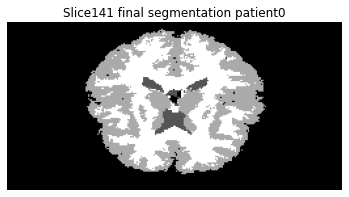

In [ ]:
# Check
slice_show(final_segmentations_non_local[0], 141, 'Slice141 final segmentation patient0')

In [ ]:
dice_scores=[]
for i in range(len(final_segmentations_non_local)): 
  dice_CSF,dice_GM, dice_WM =  diceScoreSimilarity(final_segmentations_non_local[i], val_labels[i])
  dice_scores.append([dice_CSF,dice_GM,dice_WM])
  print("For patient {}, the Dice Score for CSF, GM and WM were {:.4f},{:.4f},{:.4f}, respectively".format(i+1,dice_CSF, dice_GM, dice_WM))
dice_scores= np.array(dice_scores)
mean_dice= np.mean(dice_scores,axis=0)
print("In average, the dice score for CSF, GM and WM are {:.4f},{:.4f},{:.4f}, respectively".format(mean_dice[0],mean_dice[1],mean_dice[2]))

For patient 1, the Dice Score for CSF, GM and WM were 0.8257,0.8774,0.8633, respectively
For patient 2, the Dice Score for CSF, GM and WM were 0.6528,0.7054,0.7568, respectively
For patient 3, the Dice Score for CSF, GM and WM were 0.6307,0.7123,0.7933, respectively
For patient 4, the Dice Score for CSF, GM and WM were 0.8602,0.8670,0.8927, respectively
For patient 5, the Dice Score for CSF, GM and WM were 0.8826,0.8325,0.8923, respectively
In average, the dice score for CSF, GM and WM are 0.7704,0.7989,0.8397, respectively
